In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    df_main = pd.read_csv('Data/processed/main_dataset_clean.csv')
    user_metrics = pd.read_csv('Data/processed/user_metrics_aggregated.csv')
    print("DataFrame fue cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo no se encontró. Asegúrate de haberlo guardado en la carpeta correcta.")

DataFrame fue cargado exitosamente.


In [4]:
print(f"\nColumnas disponibles en user_metrics:")
print(user_metrics.columns.tolist())


Columnas disponibles en user_metrics:
['user_id', 'age', 'country', 'subscription_type', 'registration_date', 'total_watch_time_hours', 'registration_month', 'total_sessions', 'avg_session_duration', 'total_session_minutes', 'avg_completion_rate', 'high_engagement_rate', 'weekend_usage_rate', 'movie_preference_rate', 'content_variety']


## Data Preparation for Clustering

In [5]:
def prepare_clustering_data(user_df):
    print("PREPARACIÓN DE DATOS PARA CLUSTERING")
    print("="*60)
    
    # Seleccionar características numéricas relevantes para clustering
    clustering_features = []
    
    if 'age' in user_df.columns:
        clustering_features.append('age')
    if 'total_watch_time_hours' in user_df.columns:
        clustering_features.append('total_watch_time_hours')
    
    # Características de comportamiento
    behavioral_features = ['total_sessions', 'avg_session_duration', 'avg_completion_rate', 
                          'high_engagement_rate', 'weekend_usage_rate', 'content_variety']
    
    for feature in behavioral_features:
        if feature in user_df.columns:
            clustering_features.append(feature)
    
    # Si no tenemos suficientes características, crear algunas básicas
    if len(clustering_features) < 3:
        print("Creando características adicionales...")
        
        # Crear características derivadas básicas
        if 'total_watch_time_hours' in user_df.columns:
            user_df['watch_intensity'] = pd.cut(user_df['total_watch_time_hours'], 
                                               bins=3, labels=[1, 2, 3]).astype(float)
            clustering_features.append('watch_intensity')
        
        if 'age' in user_df.columns:
            user_df['age_group'] = pd.cut(user_df['age'], 
                                         bins=[0, 30, 45, 100], labels=[1, 2, 3]).astype(float)
            clustering_features.append('age_group')
    
    print(f"Características seleccionadas para clustering:")
    for i, feature in enumerate(clustering_features, 1):
        print(f"   {i}. {feature}")
    
    # Crear dataset para clustering (sin valores nulos)
    clustering_data = user_df[clustering_features].dropna()
    
    print(f"\nDataset para clustering:")
    print(f"   • Registros: {len(clustering_data):,}")
    print(f"   • Características: {len(clustering_features)}")
    print(f"   • Valores nulos eliminados: {len(user_df) - len(clustering_data):,}")
    
    print(f"\nEstadísticas descriptivas:")
    display(clustering_data.describe())
    
    return clustering_data, clustering_features

clustering_data, features = prepare_clustering_data(user_metrics)
3

PREPARACIÓN DE DATOS PARA CLUSTERING
Características seleccionadas para clustering:
   1. age
   2. total_watch_time_hours
   3. total_sessions
   4. avg_session_duration
   5. avg_completion_rate
   6. high_engagement_rate
   7. weekend_usage_rate
   8. content_variety

Dataset para clustering:
   • Registros: 5,000
   • Características: 8
   • Valores nulos eliminados: 0

Estadísticas descriptivas:


,age,total_watch_time_hours,total_sessions,avg_session_duration,avg_completion_rate,high_engagement_rate,weekend_usage_rate,content_variety
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,41.591000,335.041380,86.137600,82.177818,76.907296,0.470726,0.282588,40.239600
std,13.927746,220.023813,43.852495,12.645908,9.872725,0.189756,0.084641,18.739873
min,18.000000,9.800000,12.000000,33.690000,36.440000,0.000000,0.000000,7.000000
25%,30.000000,163.900000,50.000000,73.110000,69.067500,0.320000,0.230000,25.000000
50%,42.000000,312.350000,84.000000,82.890000,77.285000,0.470000,0.280000,40.000000
75%,54.000000,455.400000,116.000000,91.740000,86.130000,0.630000,0.330000,54.000000
max,65.000000,1093.100000,214.000000,131.830000,96.880000,1.000000,0.790000,92.000000


3

## Feature Scaling

ESCALAMIENTO DE CARACTERÍSTICAS
Datos escalados usando StandardScaler

Comparación antes/después del escalamiento:


,Feature,Original_Mean,Original_Std,Scaled_Mean,Scaled_Std
0,age,41.591,13.928,-0.0,1.0
1,total_watch_time_hours,335.041,220.024,-0.0,1.0
2,total_sessions,86.138,43.852,-0.0,1.0
3,avg_session_duration,82.178,12.646,0.0,1.0
4,avg_completion_rate,76.907,9.873,-0.0,1.0
5,high_engagement_rate,0.471,0.190,-0.0,1.0
6,weekend_usage_rate,0.283,0.085,-0.0,1.0
7,content_variety,40.240,18.740,-0.0,1.0


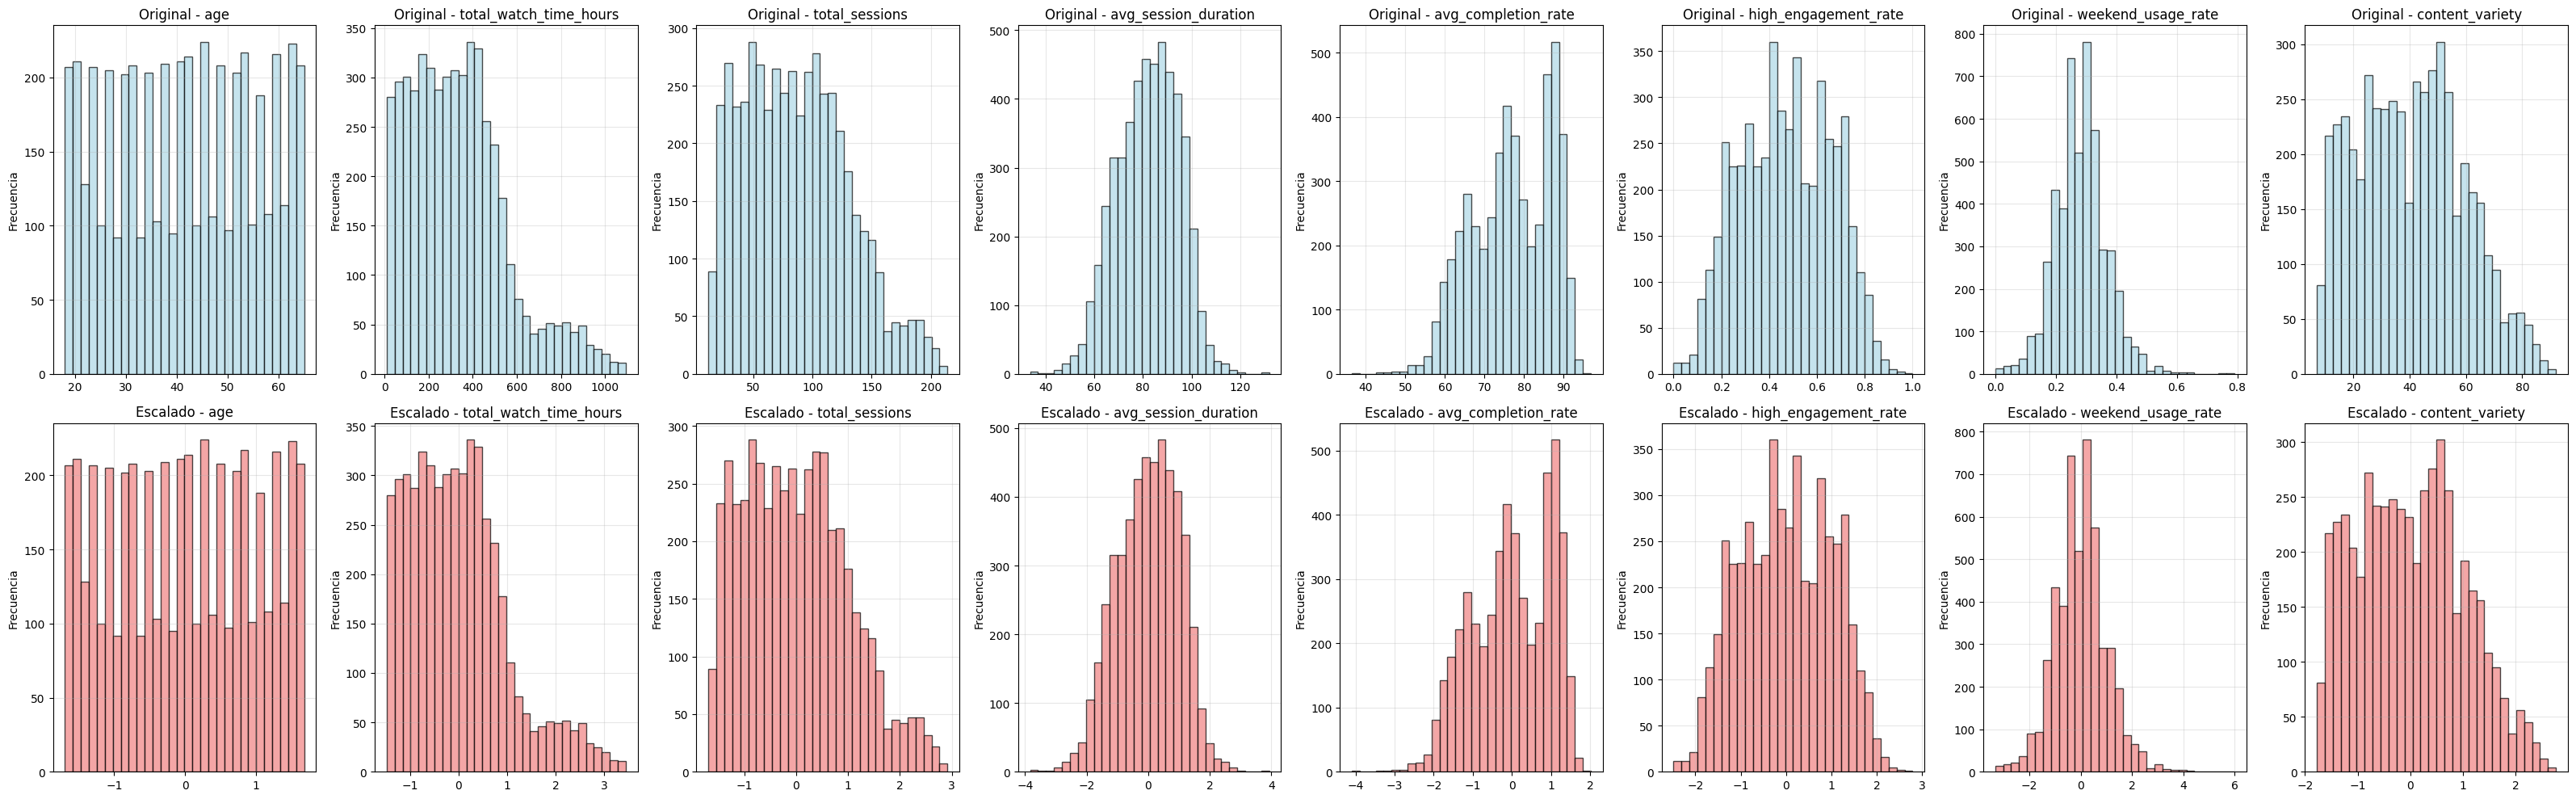

In [6]:
def scale_features(data, features):
    print("ESCALAMIENTO DE CARACTERÍSTICAS")
    print("="*50)
    
    # Inicializar el escalador
    scaler = StandardScaler()
    
    # Escalar los datos
    scaled_data = scaler.fit_transform(data[features])
    scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)
    
    print("Datos escalados usando StandardScaler")
    
    # Mostrar estadísticas antes y después del escalamiento
    print(f"\nComparación antes/después del escalamiento:")
    
    comparison_stats = pd.DataFrame({
        'Feature': features,
        'Original_Mean': data[features].mean().values,
        'Original_Std': data[features].std().values,
        'Scaled_Mean': scaled_df.mean().values,
        'Scaled_Std': scaled_df.std().values
    })
    
    display(comparison_stats.round(3))
    
    # Visualizar distribuciones antes y después
    fig, axes = plt.subplots(2, len(features), figsize=(4*len(features), 10))
    if len(features) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, feature in enumerate(features):
        # Distribución original
        axes[0, i].hist(data[feature], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
        axes[0, i].set_title(f'Original - {feature}')
        axes[0, i].set_ylabel('Frecuencia')
        axes[0, i].grid(True, alpha=0.3)
        
        # Distribución escalada
        axes[1, i].hist(scaled_df[feature], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1, i].set_title(f'Escalado - {feature}')
        axes[1, i].set_ylabel('Frecuencia')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return scaled_df, scaler

scaled_data, scaler = scale_features(clustering_data, features)

## Determining the Optimal Number of Clusters

DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS
Evaluando k desde 2 hasta 10...
   k=2: Inercia=28515.23, Silhouette=0.247
   k=3: Inercia=24055.40, Silhouette=0.220
   k=4: Inercia=21736.11, Silhouette=0.183
   k=5: Inercia=20211.70, Silhouette=0.176
   k=6: Inercia=18834.93, Silhouette=0.179
   k=7: Inercia=17632.91, Silhouette=0.173
   k=8: Inercia=16599.77, Silhouette=0.171
   k=9: Inercia=15735.40, Silhouette=0.167
   k=10: Inercia=15018.93, Silhouette=0.168


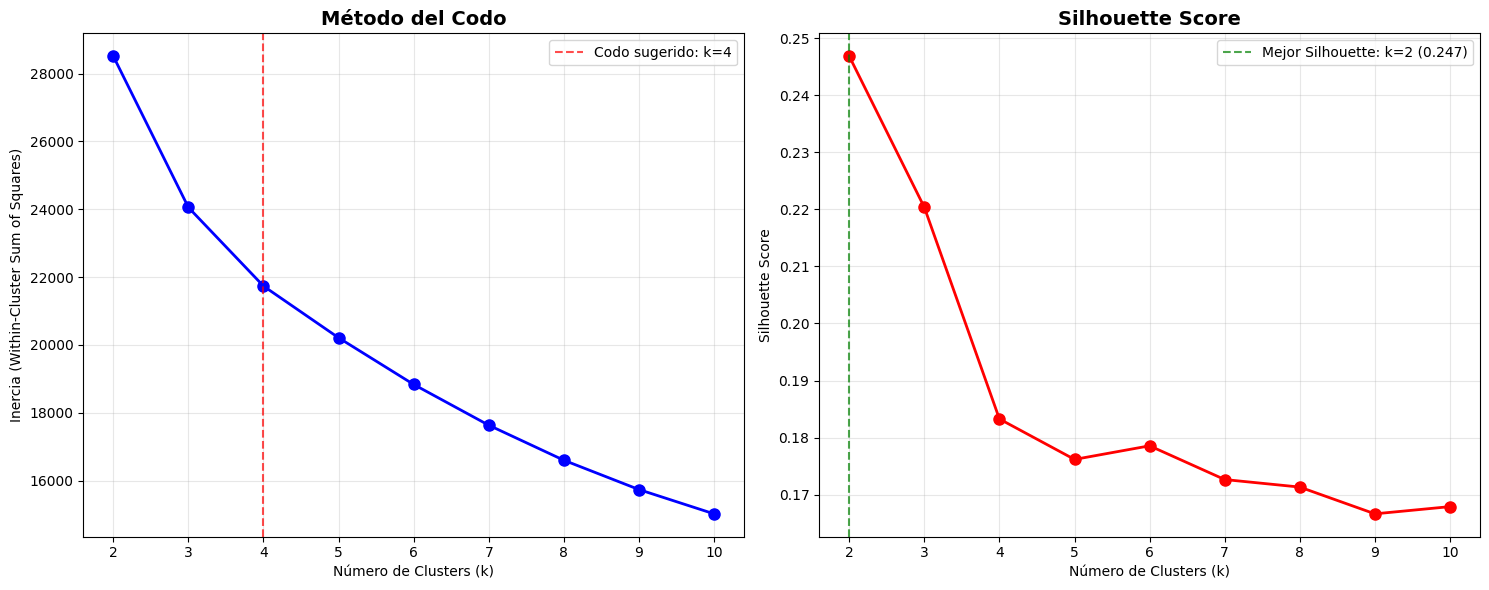


RECOMENDACIONES:
   • Método del codo sugiere: k = 4
   • Mejor Silhouette Score: k = 2 (score = 0.247)
   • K óptimo seleccionado: 2


In [7]:
def find_optimal_clusters(data, max_k=10):
    print("DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS")
    print("="*60)
    
    # Rango de número de clusters a evaluar
    k_range = range(2, min(max_k + 1, len(data) // 10))  # Mínimo 10 observaciones por cluster
    
    # Listas para almacenar métricas
    inertias = []
    silhouette_scores = []
    
    print(f"Evaluando k desde {min(k_range)} hasta {max(k_range)}...")
    
    for k in k_range:
        # Entrenar K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calcular métricas
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        inertias.append(inertia)
        silhouette_scores.append(silhouette_avg)
        
        print(f"   k={k}: Inercia={inertia:.2f}, Silhouette={silhouette_avg:.3f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Método del codo
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_title('Método del Codo', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Número de Clusters (k)')
    axes[0].set_ylabel('Inercia (Within-Cluster Sum of Squares)')
    axes[0].grid(True, alpha=0.3)
    
    # Calcular la diferencia segunda para encontrar el codo
    if len(inertias) >= 3:
        diffs = np.diff(inertias)
        diffs2 = np.diff(diffs)
        elbow_idx = np.argmax(diffs2) + 2  # +2 porque perdemos 2 elementos con las diferencias
        if elbow_idx < len(k_range):
            elbow_k = list(k_range)[elbow_idx]
            axes[0].axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, label=f'Codo sugerido: k={elbow_k}')
            axes[0].legend()
    
    # Silhouette Score
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_title('Silhouette Score', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Número de Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True, alpha=0.3)
    
    # Marcar el mejor silhouette score
    best_silhouette_idx = np.argmax(silhouette_scores)
    best_k = list(k_range)[best_silhouette_idx]
    axes[1].axvline(x=best_k, color='green', linestyle='--', alpha=0.7, 
                   label=f'Mejor Silhouette: k={best_k} ({silhouette_scores[best_silhouette_idx]:.3f})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    print(f"\nRECOMENDACIONES:")
    print(f"   • Método del codo sugiere: k = {elbow_k if 'elbow_k' in locals() else 'No determinado'}")
    print(f"   • Mejor Silhouette Score: k = {best_k} (score = {silhouette_scores[best_silhouette_idx]:.3f})")
    
    # Seleccionar k óptimo (priorizamos silhouette score)
    optimal_k = best_k
    print(f"   • K óptimo seleccionado: {optimal_k}")
    
    return optimal_k, k_range, inertias, silhouette_scores

# Encontrar número óptimo de clusters
optimal_k, k_range, inertias, silhouette_scores = find_optimal_clusters(scaled_data)
    

## Application of K-Means Clustering

In [8]:
def apply_kmeans_clustering(data, features, k, original_data):
    print(f"APLICANDO K-MEANS CLUSTERING (k={k})")
    print("="*60)
    
    # Entrenar modelo K-means final
    kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(data)
    
    # Agregar etiquetas de cluster a los datos originales
    clustered_data = original_data.copy()
    clustered_data['cluster'] = cluster_labels
    
    # Calcular métricas finales
    silhouette_avg = silhouette_score(data, cluster_labels)
    inertia = kmeans_final.inertia_
    
    print(f"Clustering completado:")
    print(f"   • Silhouette Score: {silhouette_avg:.3f}")
    print(f"   • Inercia: {inertia:.2f}")
    print(f"   • Clusters creados: {k}")
    
    # Distribución de clusters
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print(f"\nDistribución de usuarios por cluster:")
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(cluster_labels)) * 100
        print(f"   • Cluster {cluster_id}: {count:,} usuarios ({percentage:.1f}%)")
    
    return kmeans_final, clustered_data, cluster_labels

kmeans_model, clustered_data, labels = apply_kmeans_clustering(scaled_data, features, optimal_k, clustering_data)

APLICANDO K-MEANS CLUSTERING (k=2)
Clustering completado:
   • Silhouette Score: 0.247
   • Inercia: 28515.23
   • Clusters creados: 2

Distribución de usuarios por cluster:
   • Cluster 0: 2,499 usuarios (50.0%)
   • Cluster 1: 2,501 usuarios (50.0%)


## Cluster Analysis and Characterization

ANÁLISIS Y CARACTERIZACIÓN DE CLUSTERS
ESTADÍSTICAS POR CLUSTER:


age               total_watch_time_hours                 \
          mean    std median                   mean     std median   
cluster                                                              
0        38.95  13.07   37.0                 415.90  249.15  399.9   
1        44.23  14.26   47.0                 254.25  147.34  248.1   

        total_sessions               avg_session_duration  ...  \
                  mean    std median                 mean  ...   
cluster                                                    ...   
0               104.83  45.77  107.0                91.45  ...   
1                67.46  32.46   65.0                72.91  ...   

        avg_completion_rate high_engagement_rate               \
                     median                 mean   std median   
cluster                                                         
0                     86.11                 0.62  0.12   0.63   
1                     69.12                 0.32  0.12   0.32   

        weekend_usage_rate              content_variety                
                      mean   std median            mean    std median  
cluster                                                                
0                     0.29  0.08   0.28           47.98  19.14   50.0  
1                     0.28  0.09   0.28           32.50  14.71   32.0  

[2 rows x 24 columns]


PERFILES DETALLADOS DE CLUSTERS:

🔸 Cluster_1:
   • Usuarios: 2,501 (50.0%)
   • age: μ=44.23, mediana=47.00
   • total_watch_time_hours: μ=254.25, mediana=248.10
   • total_sessions: μ=67.46, mediana=65.00
   • avg_session_duration: μ=72.91, mediana=73.20
   • avg_completion_rate: μ=69.10, mediana=69.12
   • high_engagement_rate: μ=0.32, mediana=0.32
   • weekend_usage_rate: μ=0.28, mediana=0.28
   • content_variety: μ=32.50, mediana=32.00

🔸 Cluster_0:
   • Usuarios: 2,499 (50.0%)
   • age: μ=38.95, mediana=37.00
   • total_watch_time_hours: μ=415.90, mediana=399.90
   • total_sessions: μ=104.83, mediana=107.00
   • avg_session_duration: μ=91.45, mediana=91.40
   • avg_completion_rate: μ=84.72, mediana=86.11
   • high_engagement_rate: μ=0.62, mediana=0.63
   • weekend_usage_rate: μ=0.29, mediana=0.28
   • content_variety: μ=47.98, mediana=50.00


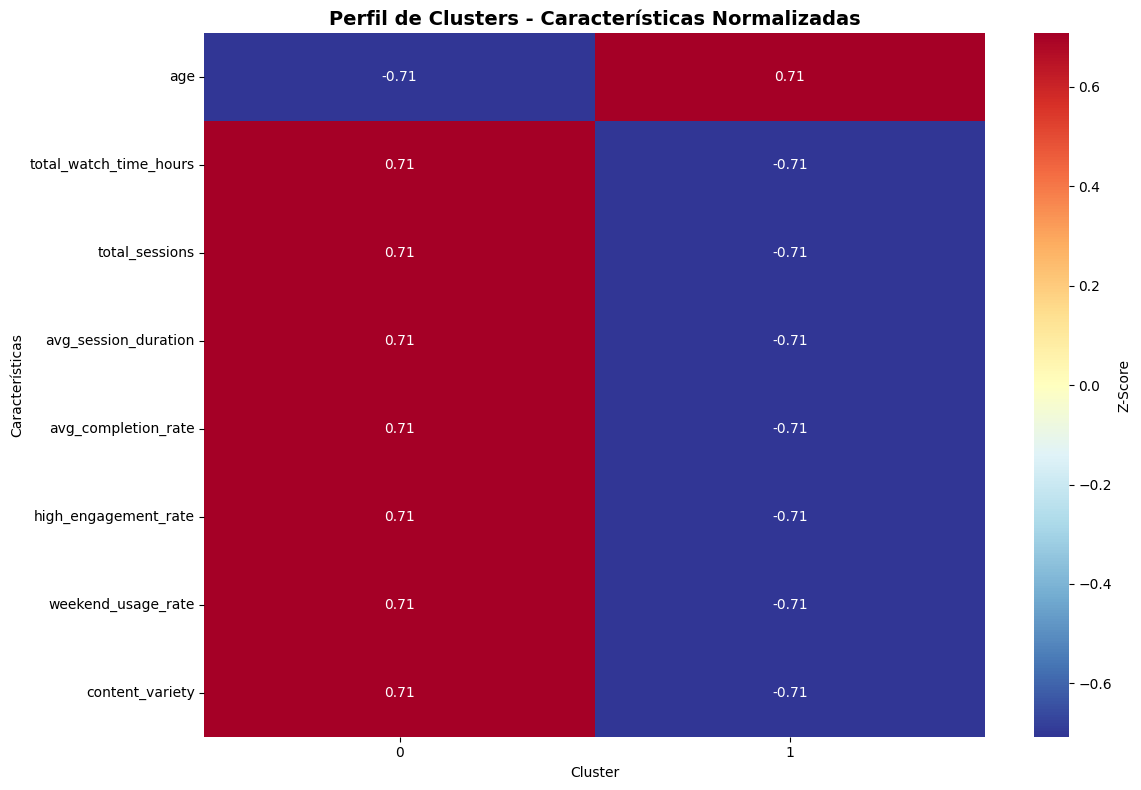

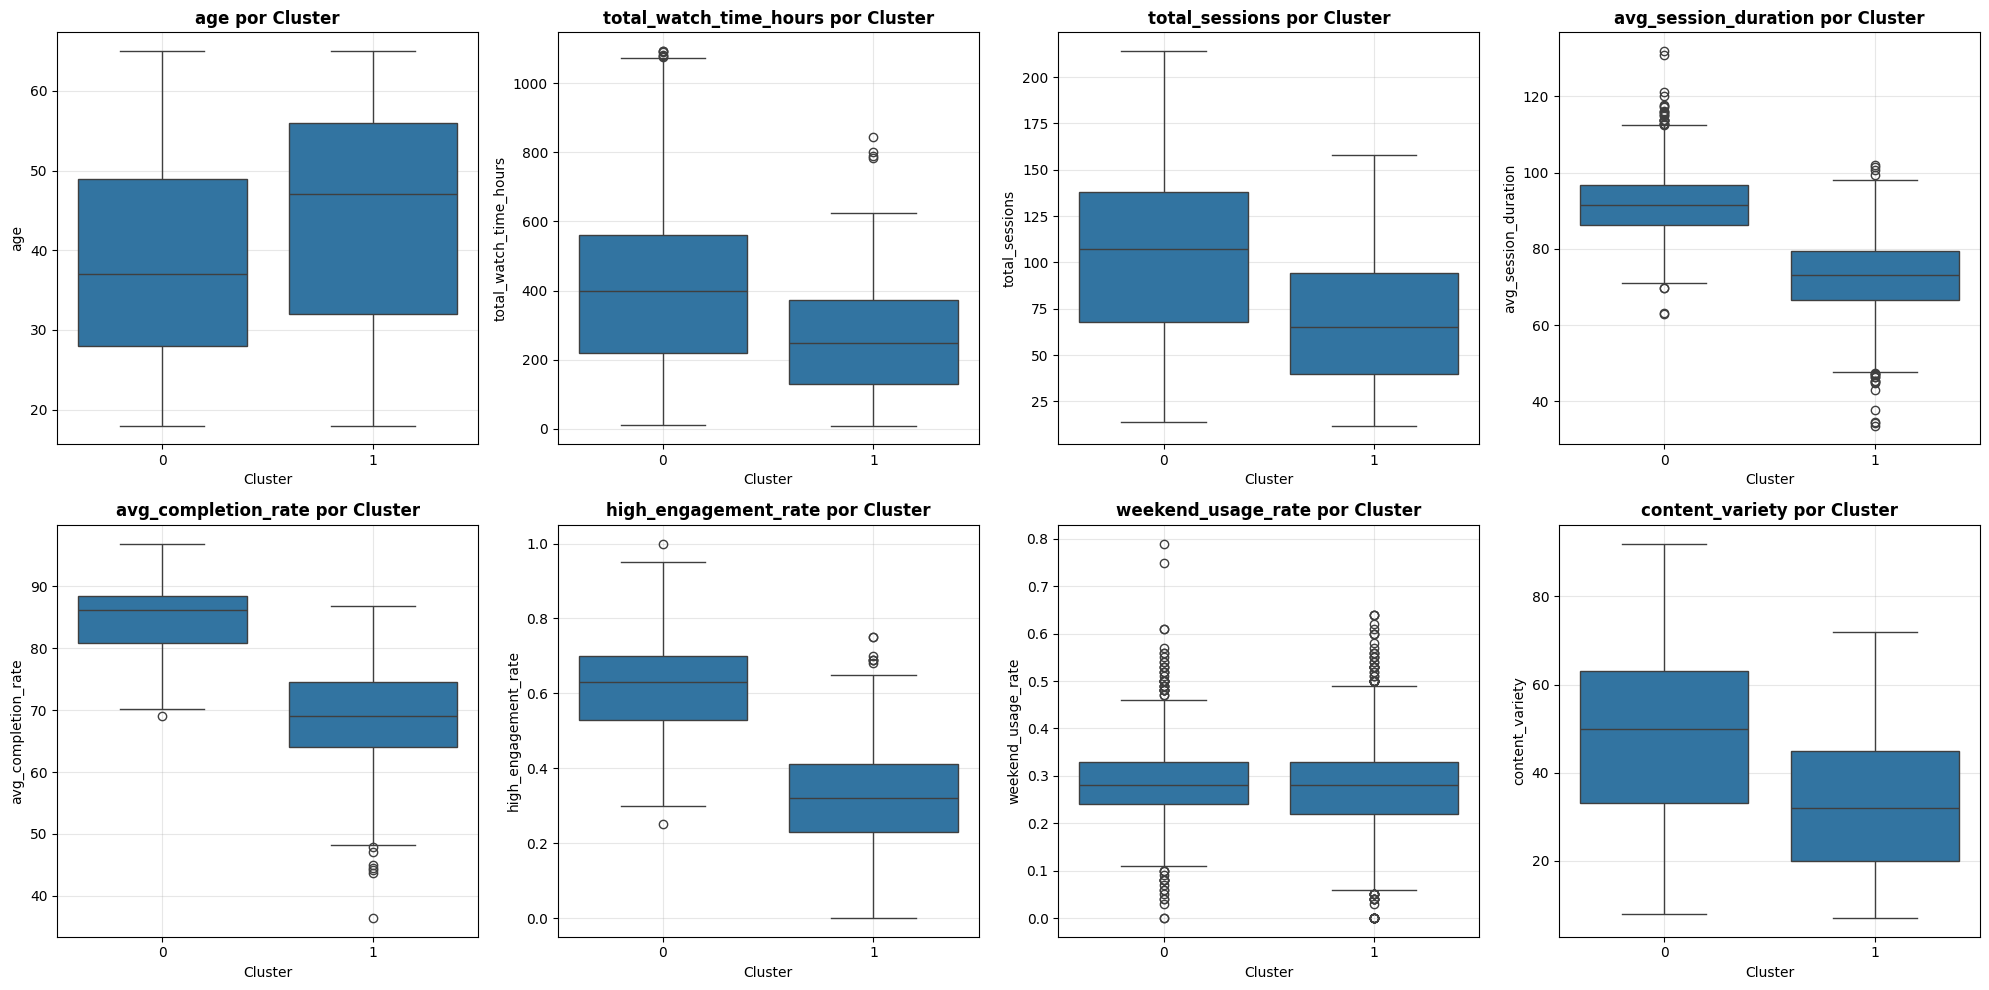

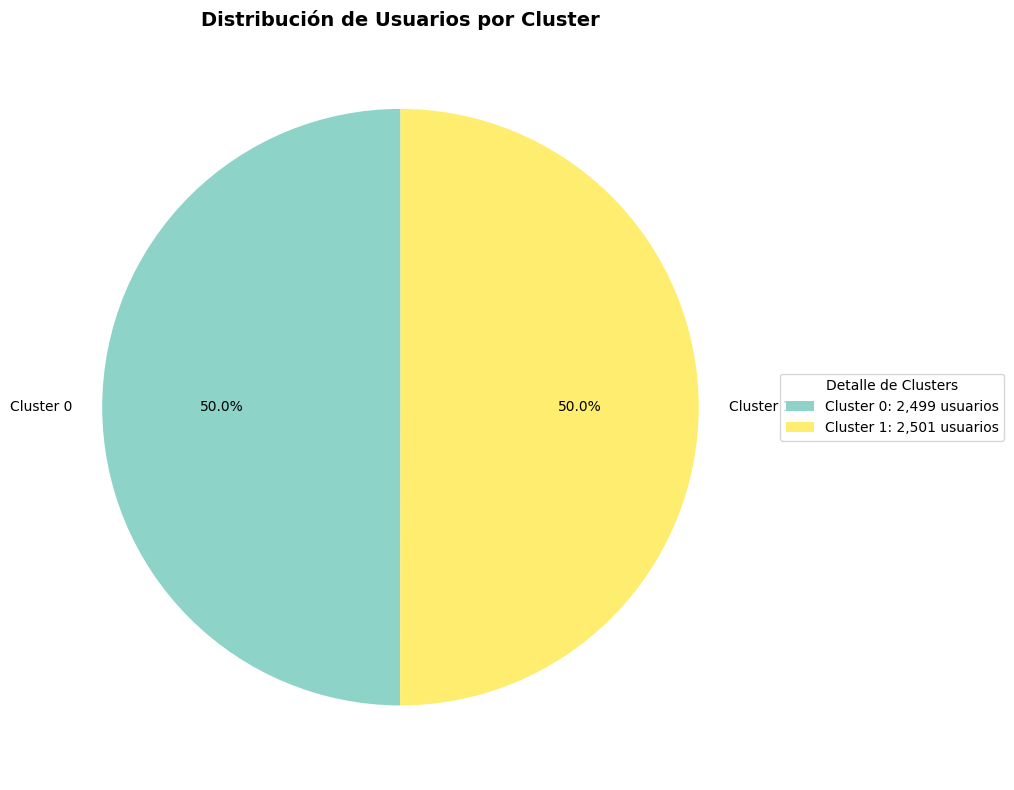

In [9]:
def analyze_clusters(clustered_data, features, labels):
    print("ANÁLISIS Y CARACTERIZACIÓN DE CLUSTERS")
    print("="*60)
    
    # Estadísticas por cluster
    cluster_stats = clustered_data.groupby('cluster')[features].agg(['mean', 'std', 'median'])
    
    print("ESTADÍSTICAS POR CLUSTER:")
    display(cluster_stats.round(2))
    
    # Crear perfiles de clusters
    cluster_profiles = {}
    
    for cluster_id in clustered_data['cluster'].unique():
        cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
        n_users = len(cluster_data)
        
        # Calcular características distintivas
        profile = {
            'n_users': n_users,
            'percentage': (n_users / len(clustered_data)) * 100
        }
        
        # Agregar estadísticas de cada feature
        for feature in features:
            profile[f'{feature}_mean'] = cluster_data[feature].mean()
            profile[f'{feature}_median'] = cluster_data[feature].median()
        
        cluster_profiles[f'Cluster_{cluster_id}'] = profile
    
    print(f"\nPERFILES DETALLADOS DE CLUSTERS:")
    for cluster_name, profile in cluster_profiles.items():
        print(f"\n🔸 {cluster_name}:")
        print(f"   • Usuarios: {profile['n_users']:,} ({profile['percentage']:.1f}%)")
        
        for feature in features:
            mean_val = profile[f'{feature}_mean']
            median_val = profile[f'{feature}_median']
            print(f"   • {feature}: μ={mean_val:.2f}, mediana={median_val:.2f}")
    
    n_features = len(features)
    n_clusters = len(clustered_data['cluster'].unique())
    
    # 1. Heatmap de características por cluster
    plt.figure(figsize=(12, 8))
    
    # Preparar datos para heatmap (medias normalizadas)
    cluster_means = clustered_data.groupby('cluster')[features].mean()
    
    # Normalizar para mejor visualización
    cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()
    
    sns.heatmap(cluster_means_normalized.T, annot=True, cmap='RdYlBu_r', center=0,
                fmt='.2f', cbar_kws={'label': 'Z-Score'})
    plt.title('Perfil de Clusters - Características Normalizadas', fontweight='bold', fontsize=14)
    plt.xlabel('Cluster')
    plt.ylabel('Características')
    plt.tight_layout()
    plt.show()
    
    # 2. Box plots por cluster para cada característica
    fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(5 * ((n_features + 1) // 2), 10))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for i, feature in enumerate(features):
        if i < len(axes):
            sns.boxplot(data=clustered_data, x='cluster', y=feature, ax=axes[i])
            axes[i].set_title(f'{feature} por Cluster', fontweight='bold')
            axes[i].set_xlabel('Cluster')
            axes[i].grid(True, alpha=0.3)
    
    # Ocultar ejes extra
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Distribución de clusters (pie chart)
    plt.figure(figsize=(10, 8))
    
    cluster_counts = clustered_data['cluster'].value_counts().sort_index()
    colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_counts)))
    
    wedges, texts, autotexts = plt.pie(cluster_counts.values, 
                                      labels=[f'Cluster {i}' for i in cluster_counts.index],
                                      autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Distribución de Usuarios por Cluster', fontweight='bold', fontsize=14)
    
    # Agregar leyenda con información adicional
    legend_labels = []
    for cluster_id, count in cluster_counts.items():
        legend_labels.append(f'Cluster {cluster_id}: {count:,} usuarios')
    
    plt.legend(wedges, legend_labels, title="Detalle de Clusters", 
              loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.tight_layout()
    plt.show()
    
    return cluster_profiles, cluster_stats

profiles, stats = analyze_clusters(clustered_data, features, labels)


## Interpretation of Clusters (User Segmentation)

In [10]:
def interpret_clusters(cluster_profiles, features):
    print("INTERPRETACIÓN Y SEGMENTACIÓN DE USUARIOS")
    print("="*60)
    
    # Función para interpretar un cluster basado en percentiles
    def interpret_single_cluster(cluster_name, profile, all_profiles):
        interpretation = {
            'name': cluster_name,
            'size': profile['n_users'],
            'percentage': profile['percentage'],
            'characteristics': [],
            'business_label': '',
            'recommendations': []
        }
        
        for feature in features:
            cluster_mean = profile[f'{feature}_mean']
            
            # Calcular promedio general
            all_means = [p[f'{feature}_mean'] for p in all_profiles.values()]
            overall_mean = np.mean(all_means)
            overall_std = np.std(all_means)
            
            # Determinar si está por encima o debajo del promedio
            z_score = (cluster_mean - overall_mean) / overall_std if overall_std > 0 else 0
            
            if z_score > 0.5:
                level = "Alto"
            elif z_score < -0.5:
                level = "Bajo"
            else:
                level = "Promedio"
            
            interpretation['characteristics'].append({
                'feature': feature,
                'value': cluster_mean,
                'level': level,
                'z_score': z_score
            })
        
        return interpretation
    
    # Interpretar cada cluster
    interpretations = {}
    for cluster_name, profile in cluster_profiles.items():
        interpretations[cluster_name] = interpret_single_cluster(cluster_name, profile, cluster_profiles)
    
    # Asignar etiquetas de negocio basadas en características
    business_labels = {}
    recommendations = {}
    
    for cluster_name, interp in interpretations.items():
        cluster_id = cluster_name.split('_')[1]
        
        # Lógica para asignar etiquetas (personalizar según características específicas)
        high_features = [c['feature'] for c in interp['characteristics'] if c['level'] == 'Alto']
        low_features = [c['feature'] for c in interp['characteristics'] if c['level'] == 'Bajo']
        
        # Determinar etiqueta de negocio
        if 'total_watch_time_hours' in high_features and 'avg_completion_rate' in high_features:
            label = "Heavy Engaged Users"
            recs = ["Programa de lealtad premium", "Early access a contenido nuevo", "Recomendaciones personalizadas avanzadas"]
        elif 'age' in high_features:
            label = "Mature Audience"
            recs = ["Contenido clásico y documentales", "Interface simplificada", "Soporte técnico dedicado"]
        elif 'total_watch_time_hours' in high_features:
            label = "Heavy Watchers"
            recs = ["Planes de suscripción premium", "Contenido en calidad 4K", "Descarga offline ilimitada"]
        elif 'avg_completion_rate' in high_features:
            label = "Quality Seekers"
            recs = ["Contenido curado de alta calidad", "Recomendaciones basadas en ratings", "Acceso anticipado a series exclusivas"]
        elif 'total_sessions' in high_features:
            label = "Frequent Users"
            recs = ["Notificaciones personalizadas", "Funciones de continuidad mejoradas", "Multi-dispositivo premium"]
        else:
            label = "👥 Casual Users"
            recs = ["Contenido popular y trending", "Ofertas promocionales", "Interfaz simplificada"]
        
        business_labels[cluster_name] = label
        recommendations[cluster_name] = recs
        
        # Mostrar interpretación detallada
        print(f"\n🔸 {cluster_name} - {label}")
        print(f"   Tamaño: {interp['size']:,} usuarios ({interp['percentage']:.1f}%)")
        print(f"   Características principales:")
        
        for char in interp['characteristics']:
            emoji = "🔺" if char['level'] == "Alto" else "🔻" if char['level'] == "Bajo" else "➖"
            print(f"      {emoji} {char['feature']}: {char['value']:.2f} ({char['level']})")
        
        print(f"   Recomendaciones de negocio:")
        for i, rec in enumerate(recs, 1):
            print(f"      {i}. {rec}")
    
    return interpretations, business_labels, recommendations

interpretations, labels, recommendations = interpret_clusters(profiles, features)


INTERPRETACIÓN Y SEGMENTACIÓN DE USUARIOS

🔸 Cluster_1 - Mature Audience
   Tamaño: 2,501 usuarios (50.0%)
   Características principales:
      🔺 age: 44.23 (Alto)
      🔻 total_watch_time_hours: 254.25 (Bajo)
      🔻 total_sessions: 67.46 (Bajo)
      🔻 avg_session_duration: 72.91 (Bajo)
      🔻 avg_completion_rate: 69.10 (Bajo)
      🔻 high_engagement_rate: 0.32 (Bajo)
      🔻 weekend_usage_rate: 0.28 (Bajo)
      🔻 content_variety: 32.50 (Bajo)
   Recomendaciones de negocio:
      1. Contenido clásico y documentales
      2. Interface simplificada
      3. Soporte técnico dedicado

🔸 Cluster_0 - Heavy Engaged Users
   Tamaño: 2,499 usuarios (50.0%)
   Características principales:
      🔻 age: 38.95 (Bajo)
      🔺 total_watch_time_hours: 415.90 (Alto)
      🔺 total_sessions: 104.83 (Alto)
      🔺 avg_session_duration: 91.45 (Alto)
      🔺 avg_completion_rate: 84.72 (Alto)
      🔺 high_engagement_rate: 0.62 (Alto)
      🔺 weekend_usage_rate: 0.29 (Alto)
      🔺 content_variety: 47.98

## Cluster Visualization

VISUALIZACIONES AVANZADAS DE CLUSTERS
Aplicando PCA para visualización 2D...
   • PC1 explica: 41.7% de la varianza
   • PC2 explica: 20.4% de la varianza
   • Total explicado: 62.1%


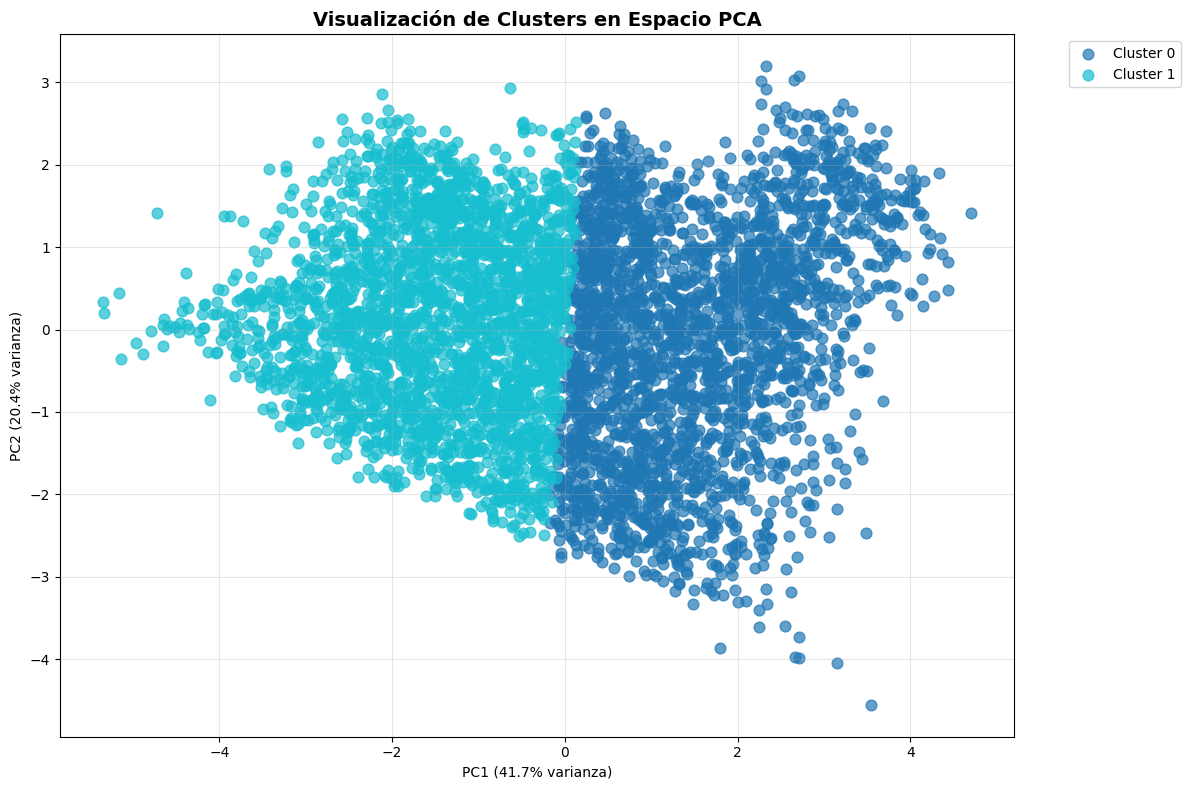


Creando Silhouette Plot...


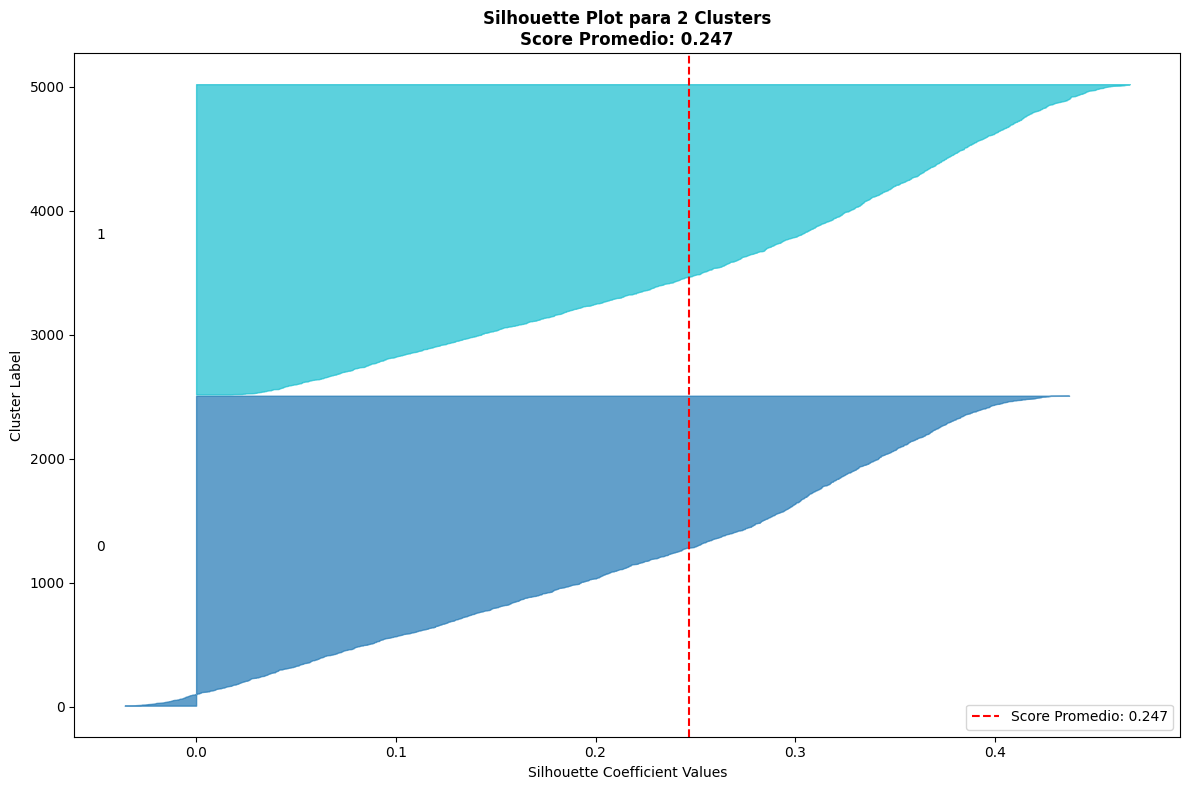


🕸️ Creando Radar Chart...


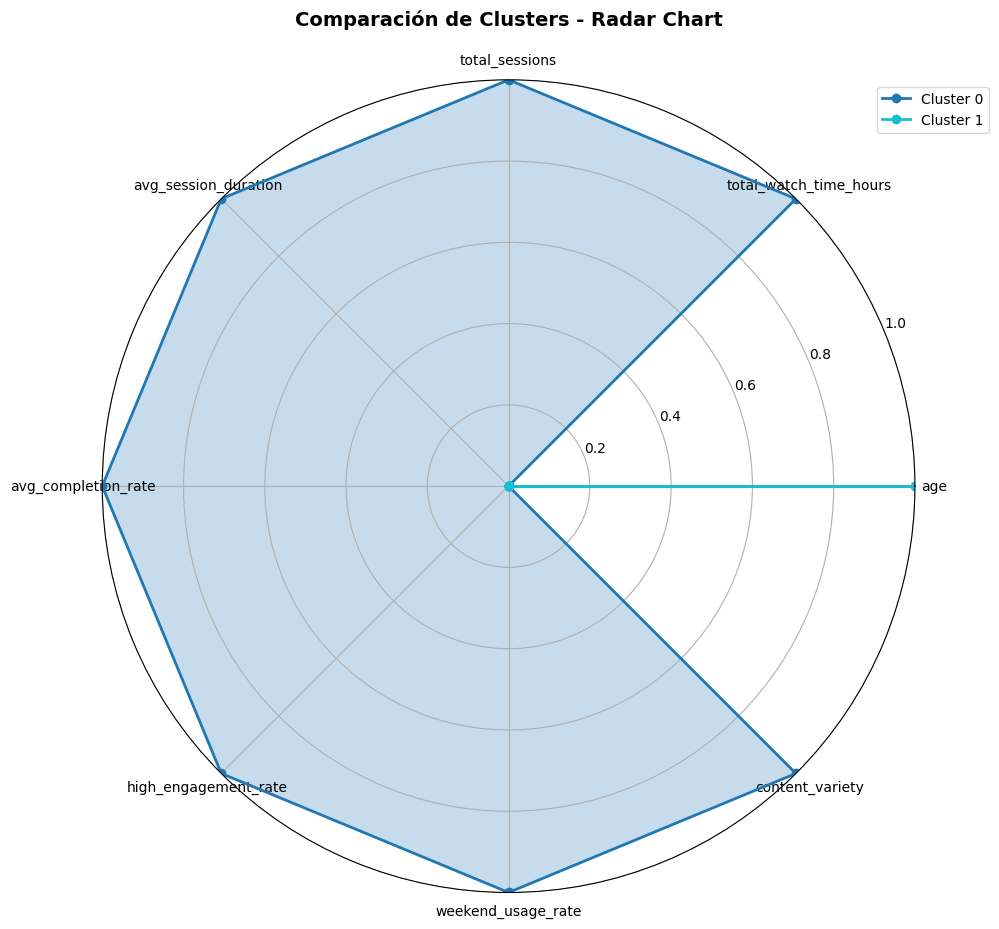

In [11]:
def create_cluster_visualizations(clustered_data, features, scaled_data, labels):
    print("VISUALIZACIONES AVANZADAS DE CLUSTERS")
    print("="*50)
    
    # 1. PCA para visualización en 2D
    print("Aplicando PCA para visualización 2D...")
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    pca_df = pd.DataFrame({
        'PC1': pd.Series(pca_result[:, 0], index=scaled_data.index),
        'PC2': pd.Series(pca_result[:, 1], index=scaled_data.index),
        'cluster': pd.Series(labels, index=scaled_data.index)
    })
    
    # Explicar varianza
    explained_variance = pca.explained_variance_ratio_
    print(f"   • PC1 explica: {explained_variance[0]:.1%} de la varianza")
    print(f"   • PC2 explica: {explained_variance[1]:.1%} de la varianza")
    print(f"   • Total explicado: {sum(explained_variance):.1%}")
    
    # Scatter plot con PCA
    plt.figure(figsize=(12, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(labels))))
    
    for i, cluster_id in enumerate(np.unique(labels)):
        cluster_points = pca_df[pca_df['cluster'] == cluster_id]
        plt.scatter(cluster_points['PC1'], cluster_points['PC2'], 
                   c=[colors[i]], label=f'Cluster {cluster_id}', 
                   alpha=0.7, s=60)
    
    plt.xlabel(f'PC1 ({explained_variance[0]:.1%} varianza)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1%} varianza)')
    plt.title('Visualización de Clusters en Espacio PCA', fontweight='bold', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Silhouette Plot
    print("\nCreando Silhouette Plot...")
    
    silhouette_avg = silhouette_score(scaled_data, labels)
    sample_silhouette_values = silhouette_samples(scaled_data, labels)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    y_lower = 10
    for i in range(len(np.unique(labels))):
        cluster_silhouette_values = sample_silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = colors[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,\
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette Coefficient Values')
    ax.set_ylabel('Cluster Label')
    ax.set_title(f'Silhouette Plot para {len(np.unique(labels))} Clusters\n'\
                f'Score Promedio: {silhouette_avg:.3f}', fontweight='bold')
    
    # Línea vertical para el score promedio
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
               label=f'Score Promedio: {silhouette_avg:.3f}')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Radar Chart para comparación de clusters
    if len(features) >= 3:
        print("\n🕸️ Creando Radar Chart...")
        
        # Preparar datos para radar chart
        cluster_means = clustered_data.groupby('cluster')[features].mean()
        
        # Normalizar entre 0 y 1 para el radar chart
        normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
        
        # Configurar radar chart
        angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # Cerrar el círculo
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        
        for i, cluster_id in enumerate(normalized_means.index):
            values = normalized_means.loc[cluster_id].values
            values = np.concatenate((values, [values[0]]))  # Cerrar el círculo
            
            ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}', color=colors[i])
            ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features)
        ax.set_ylim(0, 1)
        ax.set_title('Comparación de Clusters - Radar Chart', fontweight='bold', fontsize=14, pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0))
        plt.tight_layout()
        plt.show()
    
    return pca_df, explained_variance

pca_df, variance_explained = create_cluster_visualizations(clustered_data, features, scaled_data, clustered_data['cluster'].values)

## Preparación de Datos para Modelado Predictivo

In [12]:
def prepare_retention_model_data(user_metrics, df_main=None):
    """
    Preparar datos para modelo de predicción de retención
    """
    print(" PREPARACIÓN DE DATOS PARA MODELO DE RETENCIÓN")
    print("="*60)
    
    # Crear variable objetivo 'retained' basada en total_watch_time_hours
    if 'total_watch_time_hours' in user_metrics.columns:
        # Definir retención basada en la mediana de tiempo de visualización
        median_watch_time = user_metrics['total_watch_time_hours'].median()
        user_metrics['retained'] = (user_metrics['total_watch_time_hours'] > median_watch_time).astype(int)
        
        print(f"Variable objetivo 'retained' creada:")
        print(f"   • Criterio: total_watch_time_hours > {median_watch_time:.2f} horas")
        print(f"   • Usuarios retenidos: {user_metrics['retained'].sum():,} ({user_metrics['retained'].mean()*100:.1f}%)")
        print(f"   • Usuarios no retenidos: {(1-user_metrics['retained']).sum():,} ({(1-user_metrics['retained']).mean()*100:.1f}%)")
    else:
        print(" Error: columna 'total_watch_time_hours' no encontrada")
        return None, None
    
    # Seleccionar características para el modelo
    feature_columns = []
    
    # Características demográficas
    if 'age' in user_metrics.columns:
        feature_columns.append('age')
    
    # Características de comportamiento
    behavioral_features = ['total_sessions', 'avg_session_duration', 'avg_completion_rate', 
                          'high_engagement_rate', 'weekend_usage_rate', 'content_variety']
    
    for feature in behavioral_features:
        if feature in user_metrics.columns:
            feature_columns.append(feature)
    
    # Características categóricas
    if 'subscription_type' in user_metrics.columns:
        # Codificar subscription_type
        le = LabelEncoder()
        user_metrics['subscription_type_encoded'] = le.fit_transform(user_metrics['subscription_type'].astype(str))
        feature_columns.append('subscription_type_encoded')
        print(f"   • subscription_type codificado: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    
    # Si no tenemos suficientes características, crear algunas adicionales
    if len(feature_columns) < 3:
        print(" Creando características adicionales básicas...")
        
        if 'total_watch_time_hours' in user_metrics.columns:
            # Crear cuartiles de tiempo de visualización como feature
            user_metrics['watch_time_quartile'] = pd.qcut(user_metrics['total_watch_time_hours'], 
                                                         q=4, labels=[0, 1, 2, 3]).astype(float)
            feature_columns.append('watch_time_quartile')
        
        if 'age' in user_metrics.columns:
            # Crear grupos de edad
            user_metrics['age_group_encoded'] = pd.cut(user_metrics['age'], 
                                                      bins=[0, 30, 45, 100], labels=[0, 1, 2]).astype(float)
            feature_columns.append('age_group_encoded')
    
    print(f"\nCaracterísticas seleccionadas para el modelo:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i}. {feature}")
    
    # Crear dataset limpio para modelado
    model_data = user_metrics[feature_columns + ['retained']].dropna()
    
    print(f"\n Dataset para modelado:")
    print(f"   • Registros totales: {len(model_data):,}")
    print(f"   • Características: {len(feature_columns)}")
    print(f"   • Registros con valores nulos eliminados: {len(user_metrics) - len(model_data):,}")
    
    # Separar características y variable objetivo
    X = model_data[feature_columns]
    y = model_data['retained']
    
    # Mostrar correlaciones con la variable objetivo
    print(f"\n Correlaciones con variable objetivo (retained):")
    correlations = X.corrwith(y).sort_values(key=abs, ascending=False)
    for feature, corr in correlations.items():
        print(f"   • {feature}: {corr:.3f}")
    
    return X, y, feature_columns

# Preparar datos para modelo de retención
X, y, model_features = prepare_retention_model_data(user_metrics, df_main)

if X is not None:
    print("Datos preparados exitosamente para modelado predictivo")
else:
    print(" Error en preparación de datos")


 PREPARACIÓN DE DATOS PARA MODELO DE RETENCIÓN
Variable objetivo 'retained' creada:
   • Criterio: total_watch_time_hours > 312.35 horas
   • Usuarios retenidos: 2,500 (50.0%)
   • Usuarios no retenidos: 2,500 (50.0%)
   • subscription_type codificado: {'Basic': np.int64(0), 'Premium': np.int64(1), 'Standard': np.int64(2)}

Características seleccionadas para el modelo:
   1. age
   2. total_sessions
   3. avg_session_duration
   4. avg_completion_rate
   5. high_engagement_rate
   6. weekend_usage_rate
   7. content_variety
   8. subscription_type_encoded

 Dataset para modelado:
   • Registros totales: 5,000
   • Características: 8
   • Registros con valores nulos eliminados: 0

 Correlaciones con variable objetivo (retained):
   • avg_completion_rate: 0.200
   • high_engagement_rate: 0.195
   • avg_session_duration: 0.178
   • subscription_type_encoded: 0.093
   • age: -0.086
   • total_sessions: 0.082
   • content_variety: 0.074
   • weekend_usage_rate: -0.018
Datos preparados exito

## División de Datos y Entrenamiento del Modelo

In [13]:
def train_retention_model(X, y, feature_names, test_size=0.2):
    """
    Entrenar modelo de regresión logística para predicción de retención
    """
    print("ENTRENAMIENTO DEL MODELO DE RETENCIÓN")
    print("="*60)
    
    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"División de datos:")
    print(f"   • Entrenamiento: {len(X_train):,} muestras ({(1-test_size)*100:.0f}%)")
    print(f"   • Prueba: {len(X_test):,} muestras ({test_size*100:.0f}%)")
    print(f"   • Distribución en entrenamiento: {y_train.value_counts().to_dict()}")
    print(f"   • Distribución en prueba: {y_test.value_counts().to_dict()}")
    
    # Escalar características
    scaler_model = StandardScaler()
    X_train_scaled = scaler_model.fit_transform(X_train)
    X_test_scaled = scaler_model.transform(X_test)
    
    print(f"\n Características escaladas usando StandardScaler")
    
    # Entrenar modelo de Regresión Logística
    print(f"\nEntrenando Regresión Logística...")
    
    logistic_model = LogisticRegression(random_state=42, max_iter=1000)
    logistic_model.fit(X_train_scaled, y_train)
    
    # Realizar predicciones
    y_pred_train = logistic_model.predict(X_train_scaled)
    y_pred_test = logistic_model.predict(X_test_scaled)
    
    y_pred_proba_train = logistic_model.predict_proba(X_train_scaled)[:, 1]
    y_pred_proba_test = logistic_model.predict_proba(X_test_scaled)[:, 1]
    
    print("Modelo entrenado exitosamente")
    
    return (logistic_model, scaler_model, 
            X_train, X_test, y_train, y_test,
            X_train_scaled, X_test_scaled,
            y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test)

# Entrenar modelo si los datos están disponibles
if X is not None and y is not None:
    model_results = train_retention_model(X, y, model_features)
    (logistic_model, scaler_model, 
     X_train, X_test, y_train, y_test,
     X_train_scaled, X_test_scaled,
     y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test) = model_results
else:
    print(" No se puede entrenar el modelo sin datos preparados")

ENTRENAMIENTO DEL MODELO DE RETENCIÓN
División de datos:
   • Entrenamiento: 4,000 muestras (80%)
   • Prueba: 1,000 muestras (20%)
   • Distribución en entrenamiento: {1: 2000, 0: 2000}
   • Distribución en prueba: {0: 500, 1: 500}

 Características escaladas usando StandardScaler

Entrenando Regresión Logística...
Modelo entrenado exitosamente


## Evaluación del Modelo

In [14]:
def evaluate_model(y_true, y_pred, y_pred_proba, dataset_name=""):
    """
    Evaluar modelo usando múltiples métricas
    """
    print(f"EVALUACIÓN DEL MODELO - {dataset_name}")
    print("="*50)
    
    # Calcular métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Métricas de Rendimiento:")
    print(f"   • Accuracy (Exactitud): {accuracy:.3f}")
    print(f"   • Precision (Precisión): {precision:.3f}")
    print(f"   • Recall (Sensibilidad): {recall:.3f}")
    print(f"   • F1-Score: {f1:.3f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\nMatriz de Confusión:")
    print(f"   Predicho:    0    1")
    print(f"   Real 0:    {cm[0,0]:4d} {cm[0,1]:4d}")
    print(f"   Real 1:    {cm[1,0]:4d} {cm[1,1]:4d}")
    
    # Calcular métricas adicionales
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nMétricas Adicionales:")
    print(f"   • Verdaderos Positivos: {tp}")
    print(f"   • Verdaderos Negativos: {tn}")
    print(f"   • Falsos Positivos: {fp}")
    print(f"   • Falsos Negativos: {fn}")
    print(f"   • Especificidad: {specificity:.3f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'confusion_matrix': cm
    }

In [15]:
def plot_model_evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_proba_test):
    """
    Crear visualizaciones para evaluación del modelo
    """
    print("\nVISUALIZACIONES DE EVALUACIÓN")
    print("="*40)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Matriz de Confusión para conjunto de prueba
    cm_test = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Matriz de Confusión - Conjunto de Prueba')
    axes[0, 0].set_xlabel('Predicho')
    axes[0, 0].set_ylabel('Real')
    
    # 2. Distribución de probabilidades predichas
    axes[0, 1].hist(y_pred_proba_test[y_test == 0], bins=30, alpha=0.7, label='No Retenido', color='red')
    axes[0, 1].hist(y_pred_proba_test[y_test == 1], bins=30, alpha=0.7, label='Retenido', color='blue')
    axes[0, 1].set_xlabel('Probabilidad Predicha')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Probabilidades Predichas')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Comparación de métricas entre train y test
    train_metrics = evaluate_model(y_train, y_pred_train, None, "")
    test_metrics = evaluate_model(y_test, y_pred_test, None, "")
    
    metrics_comparison = pd.DataFrame({
        'Entrenamiento': [train_metrics['accuracy'], train_metrics['precision'], 
                         train_metrics['recall'], train_metrics['f1_score']],
        'Prueba': [test_metrics['accuracy'], test_metrics['precision'], 
                  test_metrics['recall'], test_metrics['f1_score']]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    
    metrics_comparison.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Comparación Train vs Test')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Feature Importance (coeficientes del modelo)
    if hasattr(logistic_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'Feature': model_features,
            'Coefficient': logistic_model.coef_[0],
            'Abs_Coefficient': np.abs(logistic_model.coef_[0])
        }).sort_values('Abs_Coefficient', ascending=True)
        
        colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']]
        axes[1, 1].barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.7)
        axes[1, 1].set_xlabel('Coeficiente')
        axes[1, 1].set_title('Importancia de Características')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_comparison

EVALUACIÓN COMPLETA DEL MODELO
EVALUACIÓN DEL MODELO - ENTRENAMIENTO
Métricas de Rendimiento:
   • Accuracy (Exactitud): 0.600
   • Precision (Precisión): 0.600
   • Recall (Sensibilidad): 0.599
   • F1-Score: 0.599

Matriz de Confusión:
   Predicho:    0    1
   Real 0:    1201  799
   Real 1:     803 1197

Métricas Adicionales:
   • Verdaderos Positivos: 1197
   • Verdaderos Negativos: 1201
   • Falsos Positivos: 799
   • Falsos Negativos: 803
   • Especificidad: 0.601


EVALUACIÓN DEL MODELO - PRUEBA
Métricas de Rendimiento:
   • Accuracy (Exactitud): 0.602
   • Precision (Precisión): 0.605
   • Recall (Sensibilidad): 0.586
   • F1-Score: 0.596

Matriz de Confusión:
   Predicho:    0    1
   Real 0:     309  191
   Real 1:     207  293

Métricas Adicionales:
   • Verdaderos Positivos: 293
   • Verdaderos Negativos: 309
   • Falsos Positivos: 191
   • Falsos Negativos: 207
   • Especificidad: 0.618

VISUALIZACIONES DE EVALUACIÓN
EVALUACIÓN DEL MODELO - 
Métricas de Rendimiento:
   • 

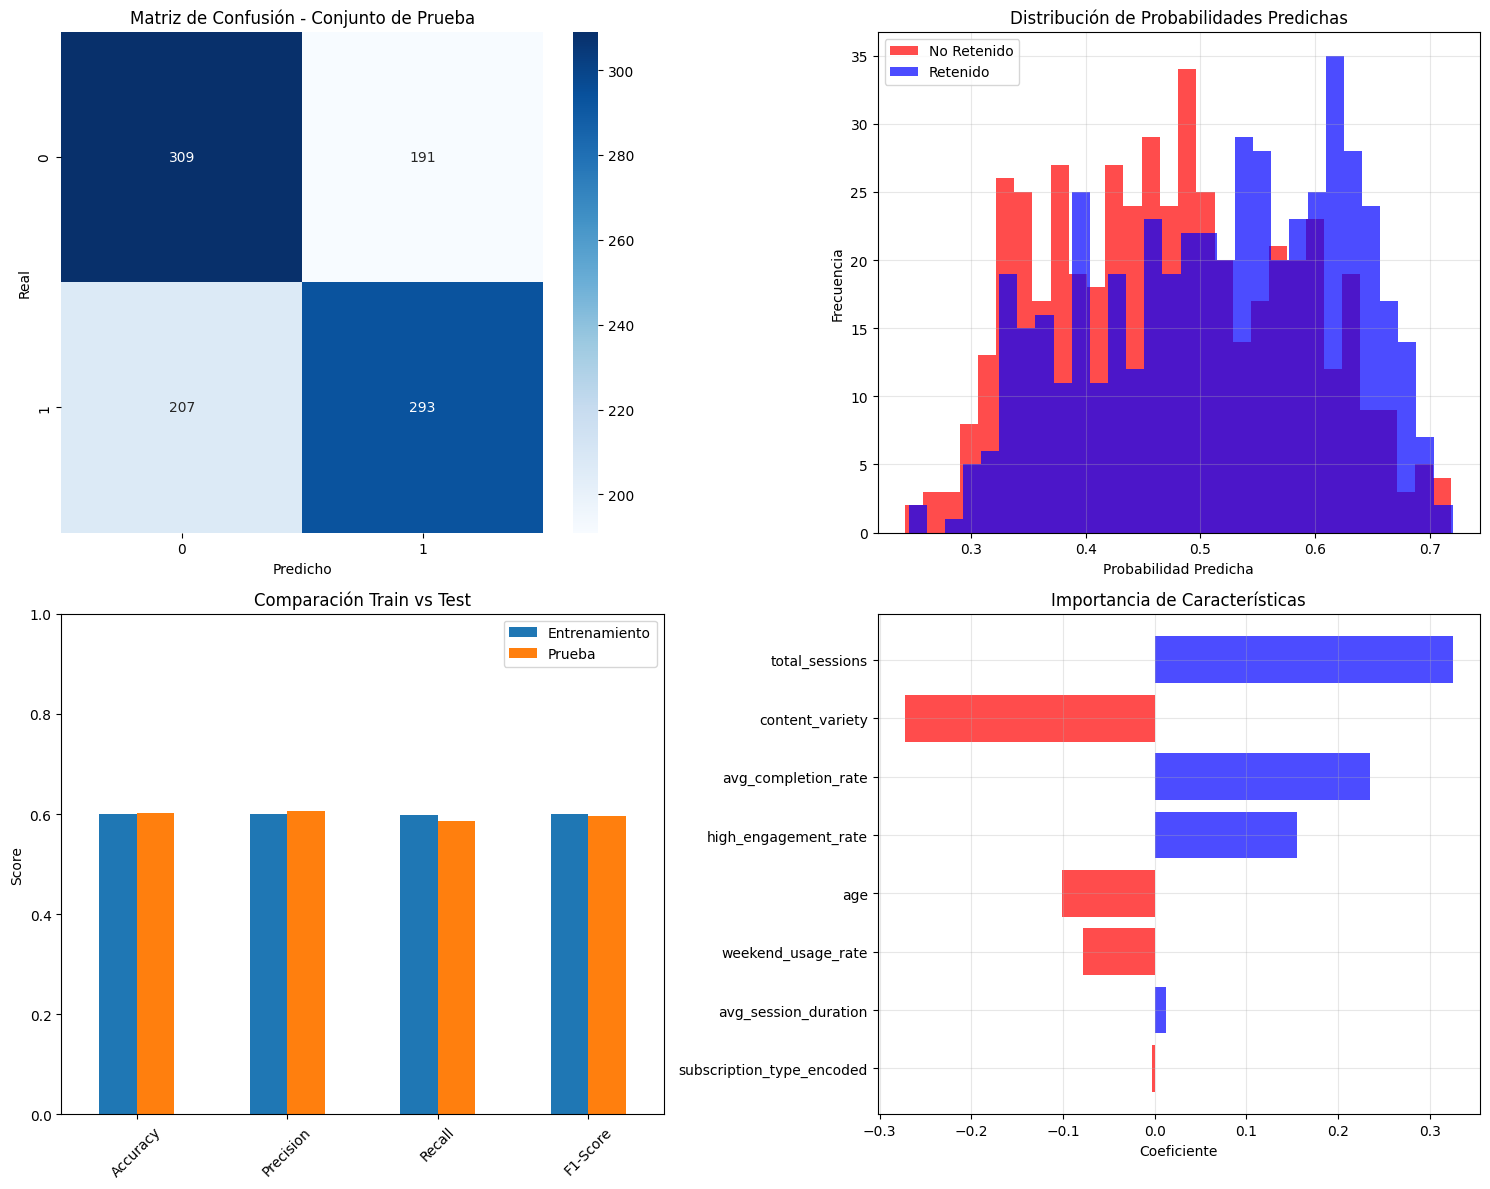


REPORTE DETALLADO DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 No Retenido       0.60      0.62      0.61       500
    Retenido       0.61      0.59      0.60       500

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



In [16]:
if 'logistic_model' in locals():
    print("EVALUACIÓN COMPLETA DEL MODELO")
    print("="*60)
    
    # Evaluar en conjunto de entrenamiento
    train_eval = evaluate_model(y_train, y_pred_train, y_pred_proba_train, "ENTRENAMIENTO")
    
    print("\n")
    
    # Evaluar en conjunto de prueba
    test_eval = evaluate_model(y_test, y_pred_test, y_pred_proba_test, "PRUEBA")
    
    # Crear visualizaciones
    metrics_df = plot_model_evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_proba_test)
    
    print(f"\nREPORTE DETALLADO DE CLASIFICACIÓN:")
    print(classification_report(y_test, y_pred_test, target_names=['No Retenido', 'Retenido']))

## Interpretación del Modelo

In [17]:
def interpret_model_results(model, feature_names, scaler, X_test, y_test):
    """
    Interpretar resultados del modelo y generar insights
    """
    print("INTERPRETACIÓN DEL MODELO")
    print("="*50)
    
    # Coeficientes del modelo
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0],
        'Abs_Coefficient': np.abs(model.coef_[0]),
        'Odds_Ratio': np.exp(model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("COEFICIENTES E INTERPRETACIÓN:")
    display(coefficients)
    
    print(f"\nINTERPRETACIÓN DE COEFICIENTES:")
    for _, row in coefficients.iterrows():
        direction = "aumenta" if row['Coefficient'] > 0 else "disminuye"
        odds_interpretation = f"multiplica las odds por {row['Odds_Ratio']:.2f}" if row['Odds_Ratio'] != 1 else "no afecta las odds"
        
        print(f"   • {row['Feature']}:")
        print(f"     - Coeficiente: {row['Coefficient']:.3f}")
        print(f"     - {direction} la probabilidad de retención")
        print(f"     - Odds Ratio: {odds_interpretation}")
    
    # Características más importantes
    print(f"\nTOP 3 CARACTERÍSTICAS MÁS IMPORTANTES:")
    for i, (_, row) in enumerate(coefficients.head(3).iterrows(), 1):
        impact = "Positivo" if row['Coefficient'] > 0 else "Negativo"
        print(f"   {i}. {row['Feature']} (Impacto {impact})")
    
    # Intercept
    intercept = model.intercept_[0]
    baseline_odds = np.exp(intercept)
    baseline_prob = baseline_odds / (1 + baseline_odds)
    
    print(f"\nLÍNEA BASE DEL MODELO:")
    print(f"   • Intercept: {intercept:.3f}")
    print(f"   • Probabilidad base de retención: {baseline_prob:.3f} ({baseline_prob*100:.1f}%)")
    
    return coefficients

# Interpretar modelo si está disponible
if 'logistic_model' in locals():
    model_interpretation = interpret_model_results(logistic_model, model_features, scaler_model, X_test, y_test)


INTERPRETACIÓN DEL MODELO
COEFICIENTES E INTERPRETACIÓN:


,Feature,Coefficient,Abs_Coefficient,Odds_Ratio
1,total_sessions,0.325020,0.325020,1.384058
6,content_variety,-0.272305,0.272305,0.761622
3,avg_completion_rate,0.234714,0.234714,1.264547
4,high_engagement_rate,0.154942,0.154942,1.167591
0,age,-0.101529,0.101529,0.903455
5,weekend_usage_rate,-0.078697,0.078697,0.924320
2,avg_session_duration,0.012655,0.012655,1.012735
7,subscription_type_encoded,-0.003247,0.003247,0.996758



INTERPRETACIÓN DE COEFICIENTES:
   • total_sessions:
     - Coeficiente: 0.325
     - aumenta la probabilidad de retención
     - Odds Ratio: multiplica las odds por 1.38
   • content_variety:
     - Coeficiente: -0.272
     - disminuye la probabilidad de retención
     - Odds Ratio: multiplica las odds por 0.76
   • avg_completion_rate:
     - Coeficiente: 0.235
     - aumenta la probabilidad de retención
     - Odds Ratio: multiplica las odds por 1.26
   • high_engagement_rate:
     - Coeficiente: 0.155
     - aumenta la probabilidad de retención
     - Odds Ratio: multiplica las odds por 1.17
   • age:
     - Coeficiente: -0.102
     - disminuye la probabilidad de retención
     - Odds Ratio: multiplica las odds por 0.90
   • weekend_usage_rate:
     - Coeficiente: -0.079
     - disminuye la probabilidad de retención
     - Odds Ratio: multiplica las odds por 0.92
   • avg_session_duration:
     - Coeficiente: 0.013
     - aumenta la probabilidad de retención
     - Odds Ratio: mul

## Recomendaciones de Negocio

In [18]:
def generate_business_recommendations(cluster_interpretations, model_interpretation, test_eval):
    """
    Generar recomendaciones de negocio basadas en clustering y modelo predictivo
    """
    print("RECOMENDACIONES DE NEGOCIO")
    print("="*60)
    
    print("BASADAS EN SEGMENTACIÓN DE USUARIOS (CLUSTERING):")
    print("-" * 50)
    
    if 'labels' in locals():
        # Recomendaciones por cluster
        for cluster_name, interpretation in cluster_interpretations.items():
            cluster_id = cluster_name.split('_')[1]
            label = labels.get(cluster_name, "Segmento de Usuarios")
            
            print(f"\n🔸 {label}:")
            print(f"   👥 Tamaño: {interpretation['size']:,} usuarios ({interpretation['percentage']:.1f}%)")
            
            # Estrategias específicas basadas en características
            high_features = [c['feature'] for c in interpretation['characteristics'] if c['level'] == 'Alto']
            low_features = [c['feature'] for c in interpretation['characteristics'] if c['level'] == 'Bajo']
            
            strategies = []
            if 'total_watch_time_hours' in high_features:
                strategies.append("Programa de fidelización con beneficios exclusivos")
                strategies.append("Acceso temprano a contenido premium")
            
            if 'avg_completion_rate' in high_features:
                strategies.append("Recomendaciones de contenido de alta calidad")
                strategies.append("Alertas de nuevos episodios/temporadas")
            
            if 'age' in high_features:
                strategies.append("Contenido curado para audiencia madura")
                strategies.append("Interface simplificada y accesible")
            
            if 'total_sessions' in high_features:
                strategies.append("Funciones de continuidad mejoradas")
                strategies.append("Sincronización multi-dispositivo")
            
            if not strategies:
                strategies = ["Ofertas promocionales para incrementar engagement",
                            "Contenido popular y trending para atraer interés"]
            
            print(f"   💡 Estrategias recomendadas:")
            for i, strategy in enumerate(strategies[:3], 1):
                print(f"      {i}. {strategy}")
    
    print(f"\nBASADAS EN MODELO PREDICTIVO:")
    print("-" * 50)
    
    if 'model_interpretation' in locals():
        # Factores más importantes para retención
        top_features = model_interpretation.head(3)
        
        print("FACTORES CLAVE PARA LA RETENCIÓN:")
        for i, (_, feature) in enumerate(top_features.iterrows(), 1):
            impact_type = "Incrementar" if feature['Coefficient'] > 0 else "Optimizar"
            print(f"   {i}. {feature['Feature']} ({impact_type})")
            
            # Recomendaciones específicas por característica
            if 'completion_rate' in feature['Feature']:
                print(f"      → Mejorar calidad y relevancia del contenido")
                print(f"      → Optimizar duración de episodios/películas")
            elif 'session' in feature['Feature']:
                print(f"      → Facilitar el acceso a la plataforma")
                print(f"      → Implementar notificaciones personalizadas")
            elif 'age' in feature['Feature']:
                print(f"      → Personalizar experiencia por grupo etario")
                print(f"      → Adaptar catálogo a preferencias demográficas")
    
    # Métricas del modelo para contexto
    if 'test_eval' in locals():
        print(f"\nCONFIABILIDAD DE LAS PREDICCIONES:")
        print(f"   • Exactitud del modelo: {test_eval['accuracy']:.1%}")
        print(f"   • Precisión: {test_eval['precision']:.1%}")
        print(f"   • Recall: {test_eval['recall']:.1%}")
    
    print(f"\nACCIONES PRIORITARIAS:")
    print("-" * 30)
    
    priority_actions = [
        "1. Implementar sistema de recomendaciones personalizado por cluster",
        "2. Desarrollar campañas de retención dirigidas por segmento",
        "3. Optimizar características que más impactan la retención",
        "4. Monitorear métricas de engagement por cluster mensualmente",
        "5. A/B testing de estrategias específicas por segmento"
    ]
    
    for action in priority_actions:
        print(f"   {action}")
    
    print(f"\nMÉTRICAS DE SEGUIMIENTO RECOMENDADAS:")
    print("-" * 40)
    
    metrics = [
        "• Tasa de retención por cluster (mensual)",
        "• Tiempo promedio de visualización por segmento",
        "• Tasa de completion por tipo de contenido",
        "• Engagement score por usuario",
        "• ROI de campañas segmentadas"
    ]
    
    for metric in metrics:
        print(f"   {metric}")

# Generar recomendaciones
if 'interpretations' in locals() and 'model_interpretation' in locals():
    generate_business_recommendations(interpretations, model_interpretation, test_eval)



RECOMENDACIONES DE NEGOCIO
BASADAS EN SEGMENTACIÓN DE USUARIOS (CLUSTERING):
--------------------------------------------------

BASADAS EN MODELO PREDICTIVO:
--------------------------------------------------
FACTORES CLAVE PARA LA RETENCIÓN:
   1. total_sessions (Incrementar)
      → Facilitar el acceso a la plataforma
      → Implementar notificaciones personalizadas
   2. content_variety (Optimizar)
   3. avg_completion_rate (Incrementar)
      → Mejorar calidad y relevancia del contenido
      → Optimizar duración de episodios/películas

CONFIABILIDAD DE LAS PREDICCIONES:
   • Exactitud del modelo: 60.2%
   • Precisión: 60.5%
   • Recall: 58.6%

ACCIONES PRIORITARIAS:
------------------------------
   1. Implementar sistema de recomendaciones personalizado por cluster
   2. Desarrollar campañas de retención dirigidas por segmento
   3. Optimizar características que más impactan la retención
   4. Monitorear métricas de engagement por cluster mensualmente
   5. A/B testing de estra

In [19]:
print("RESUMEN - CLUSTERING Y MODELADO PREDICTIVO")
print("="*70)

summary_points = [
    "CLUSTERING (SEGMENTACIÓN DE USUARIOS):",
    f"   • {optimal_k if 'optimal_k' in locals() else 'N'} clusters identificados usando K-means",
    f"   • Silhouette Score: {silhouette_scores[k_range.index(optimal_k)] if 'optimal_k' in locals() and optimal_k in k_range else 'N/A'}",
    "   • Cada cluster representa un segmento único de usuarios con comportamientos similares",
    "   • Perfiles detallados creados para estrategias de marketing dirigidas",
    "",
    "MODELO PREDICTIVO DE RETENCIÓN:",
    f"   • Algoritmo: Regresión Logística",
    f"   • Accuracy: {test_eval['accuracy']:.1%} en conjunto de prueba" if 'test_eval' in locals() else "   • Accuracy: N/A",
    f"   • Precision: {test_eval['precision']:.1%}" if 'test_eval' in locals() else "   • Precision: N/A", 
    f"   • Recall: {test_eval['recall']:.1%}" if 'test_eval' in locals() else "   • Recall: N/A",
    "   • Variables más importantes identificadas para retención",
    "",
    "INSIGHTS PRINCIPALES:",
    "   • Usuarios segmentados exitosamente en grupos comportamentales",
    "   • Factores clave de retención cuantificados y priorizados",
    "   • Estrategias específicas desarrolladas por segmento",
    "   • Base sólida para toma de decisiones basada en datos",
]

for point in summary_points:
    print(point)


# Guardar resultados finales
if 'clustered_data' in locals():
    # Guardar datos con clusters asignados
    final_user_data = user_metrics.merge(
        clustered_data[['user_id', 'cluster']] if 'user_id' in clustered_data.columns else 
        pd.DataFrame({'cluster': labels}, index=clustered_data.index), 
        left_index=True, right_index=True, how='left'
    )
    
    

RESUMEN - CLUSTERING Y MODELADO PREDICTIVO
CLUSTERING (SEGMENTACIÓN DE USUARIOS):
   • 2 clusters identificados usando K-means
   • Silhouette Score: 0.24682221214291952
   • Cada cluster representa un segmento único de usuarios con comportamientos similares
   • Perfiles detallados creados para estrategias de marketing dirigidas

MODELO PREDICTIVO DE RETENCIÓN:
   • Algoritmo: Regresión Logística
   • Accuracy: 60.2% en conjunto de prueba
   • Precision: 60.5%
   • Recall: 58.6%
   • Variables más importantes identificadas para retención

INSIGHTS PRINCIPALES:
   • Usuarios segmentados exitosamente en grupos comportamentales
   • Factores clave de retención cuantificados y priorizados
   • Estrategias específicas desarrolladas por segmento
   • Base sólida para toma de decisiones basada en datos
